In [1]:
from sklearnex import patch_sklearn
patch_sklearn()
import facet_ml
from facet_ml.classification.model_using import ModelApplication
from facet_ml.classification.model_training import load_feature_config
from facet_ml.static.path import STATIC_MODELS, STATIC_FOLDER
from sklearn import metrics
import glob
import pandas as pd
import numpy as np
import pickle
import os
import shap
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
### EACH VARIABLE HERE NEEDS INPIUT ###

# Load Data from training
training_folder = os.path.join("..","..","ProcessedData","Training_Data_20231106")

csv_list = glob.glob(os.path.join(training_folder,"*"))
df_list = [pd.read_csv(csv,index_col=0) for csv in csv_list]
df_total = pd.concat(df_list)

# Process data

df_total = pd.read_csv( os.path.join("..","..","ProcessedData","Training_Data_20240216","2024_02_27_Rachel-C_Processed.csv") )
df_total.reset_index(drop=True)
df_total.replace([np.inf, -np.inf], np.nan, inplace=True)
df_total.dropna(axis=0,inplace=True)
df_total.drop(labels=["label","Filename","Region"],axis=1,inplace=True)

# Get and use features
features_oi = load_feature_config("2024_features-agnostic")
X = df_total[features_oi]
y = df_total.Labels

In [3]:
# Model_paths
model_folder = STATIC_FOLDER / "Models" / "2024_02__original_2024_features-agnostic"
crystal_multicrystal = model_folder / "RF_C_MC.sav"
crystalline_noncrystalline = model_folder / "RF_C-MC_I.sav"
crystal_multicrystal_incomplete = model_folder / "RF_C_MC_I.sav"
# Load models
def load_model(pickle_path:str):
    with open(pickle_path,"rb") as f:
        model = pickle.load(f)

    return model

#C_v_MC = load_model(STATIC_MODELS["crystal_multicrystal"])
#Crys_v_Nocrys = load_model(STATIC_MODELS["crystalline_noncrystalline"])
#total = load_model(STATIC_MODELS["crystal_multicrystal_incomplete"])
C_v_MC = load_model(crystal_multicrystal)
Crys_v_Nocrys = load_model(crystalline_noncrystalline)
total = load_model(crystal_multicrystal_incomplete)

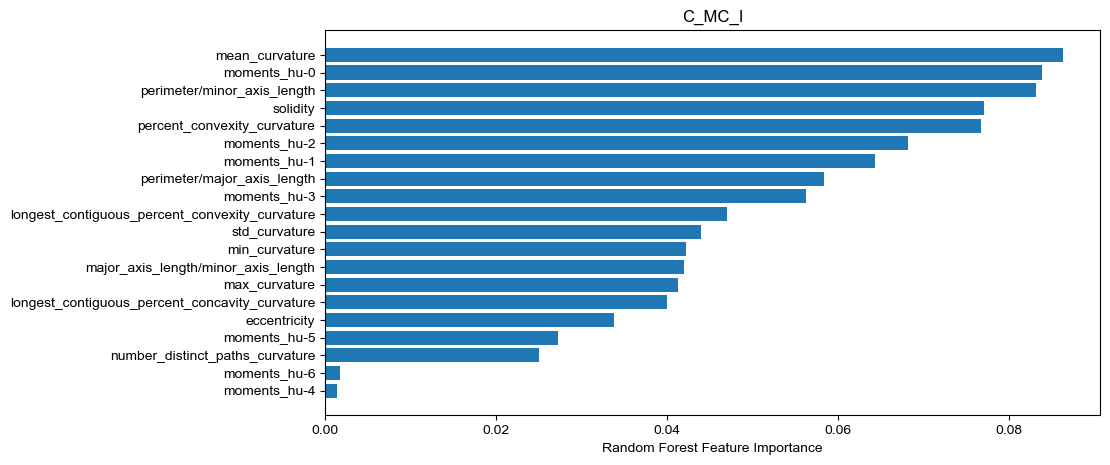

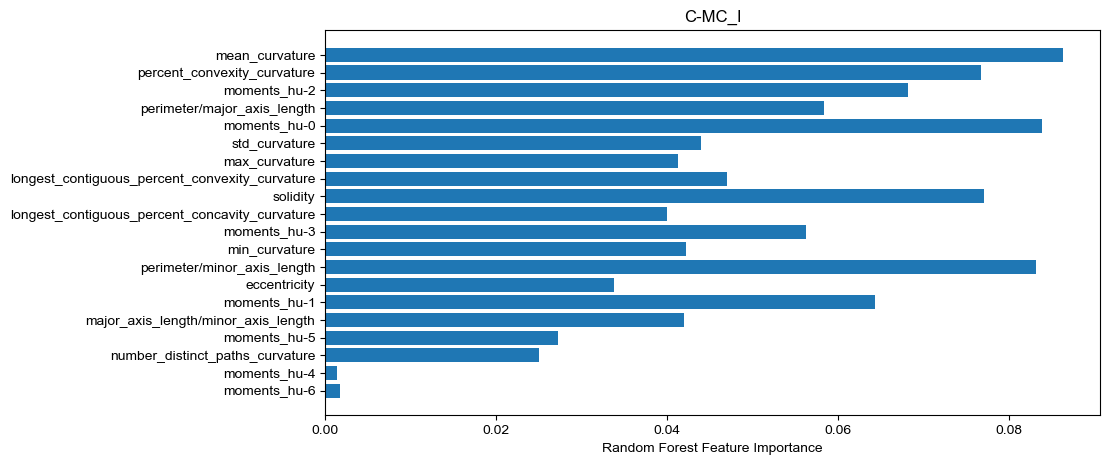

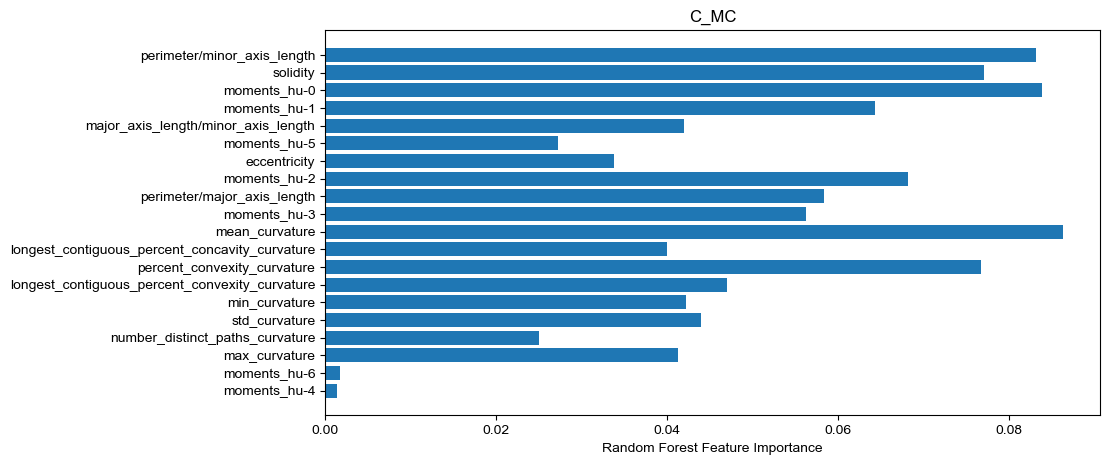

In [4]:
# MDI
def feature_mdi_importance_model(model_run,title):
    sorted_idx = model_run["model"].feature_importances_.argsort()
    fig, ax = plt.subplots(figsize=(10,5))
    ax.barh(X.columns[sorted_idx], total["model"].feature_importances_[sorted_idx])
    ax.set_xlabel("Random Forest Feature Importance")
    ax.set_title(title)
    #plt.show()
    fig.savefig(f"S1_impurity_{title}.png")

feature_mdi_importance_model(total,"C_MC_I")
feature_mdi_importance_model(Crys_v_Nocrys,"C-MC_I")
feature_mdi_importance_model(C_v_MC,"C_MC")


In [6]:
total

{'model': RandomForestClassifier(min_samples_leaf=3, n_estimators=64),
 'f1_score': 0.7595337977608537,
 'confusion_matrix': array([[[192,  19],
         [ 30,  85]],
 
        [[247,  10],
         [ 26,  43]],
 
        [[139,  45],
         [ 18, 124]]], dtype=int64),
 'X_test':       solidity  major_axis_length/minor_axis_length  \
 1029  0.838778                             1.719522   
 407   0.944079                             1.827824   
 378   0.954588                             1.346831   
 580   0.970178                             1.550390   
 199   0.836022                             1.906860   
 ...        ...                                  ...   
 498   0.840263                             2.149153   
 1128  0.863415                             3.051833   
 446   0.700662                             1.994944   
 644   0.961538                             1.414460   
 1614  0.939394                             1.267304   
 
       perimeter/major_axis_length  perimete

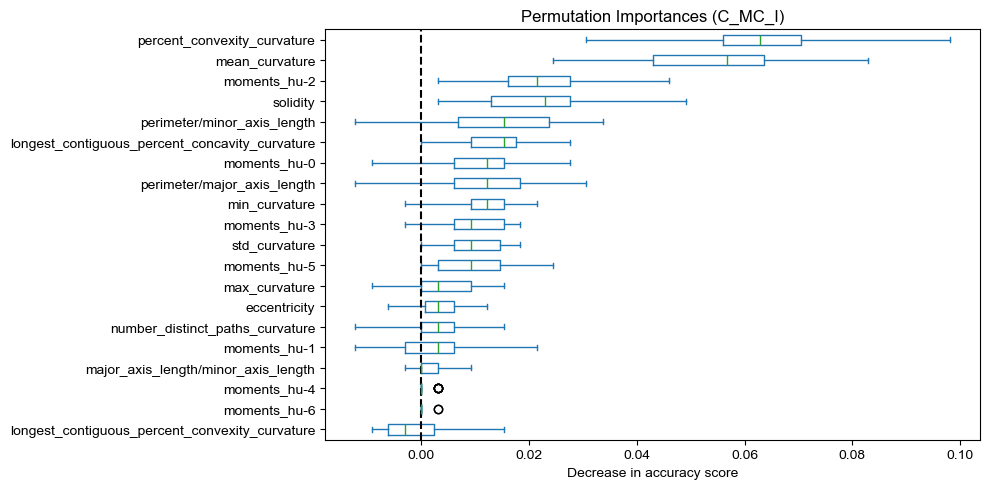

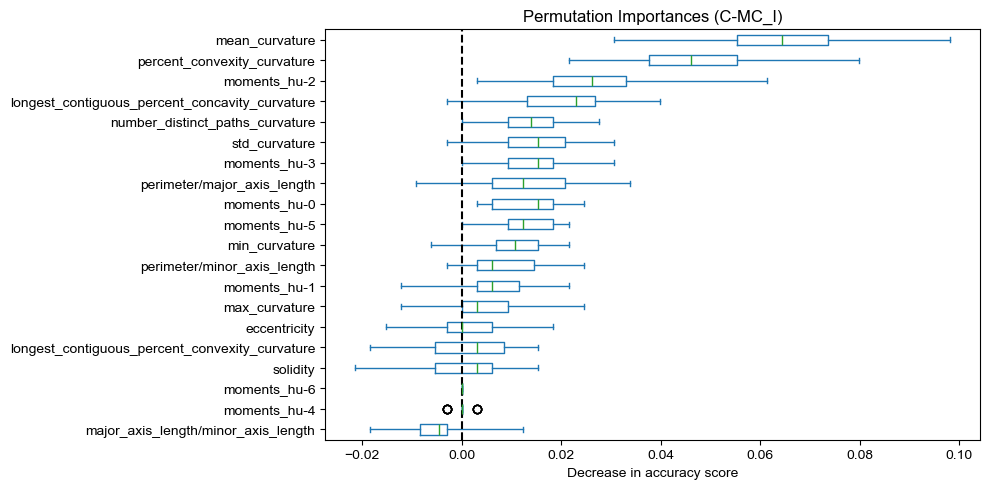

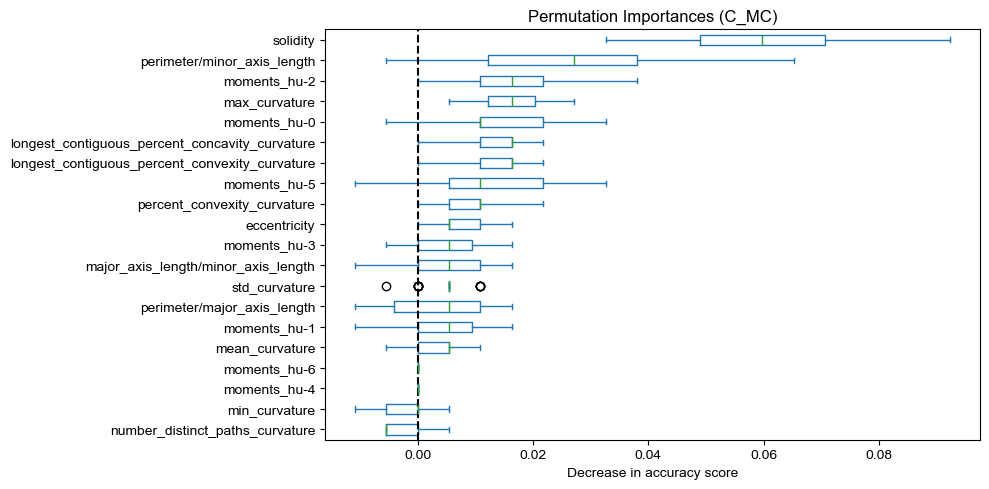

In [10]:
# Permutative
from sklearn.inspection import permutation_importance

def feature_permutative_importance_model(model_run,title):
    model = model_run["model"]
    X_test = model_run["X_test"]
    y_test = model_run["y_test"]
    r = permutation_importance(model,X_test,y_test,
                               n_repeats=30,
                               random_state=0)
    sorted_importances_idx = r.importances_mean.argsort()
    importances = pd.DataFrame(
        r.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    fig, ax = plt.subplots(figsize=(10,5))
    importances.plot.box(vert=False, whis=10, ax=ax)
    ax.set_title(f"Permutation Importances ({title})")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    fig.savefig(f"S1_permutative_{title}.png")

feature_permutative_importance_model(total,"C_MC_I")
feature_permutative_importance_model(Crys_v_Nocrys,"C-MC_I")
feature_permutative_importance_model(C_v_MC,"C_MC")


In [ ]:
def shapley_model_review(model_run,name_mod=""):
    # Combine test and train for a single X
    X = pd.concat([model_run["X_train"],model_run["X_test"]])
    y = pd.concat([model_run["y_train"],model_run["y_test"]])

    explainer = shap.TreeExplainer(total["model"],X,)
    shap_values = explainer(X,check_additivity=False)

    # Get classes
    classes = model_run["model"].classes_

    # Generate violin plots
    for ii, class_oi in enumerate(classes):
        plt.clf()
        shap.plots.violin(shap_values[:,:,ii],show=False,plot_type="layered_violin") # Crystal
        fig = plt.gcf()
        plt.tight_layout()
        fig.suptitle(f"{class_oi} Violin Plot")
        fig.savefig(f"S1_Shapley_{class_oi}_{name_mod}.png",)
        #plt.show()
        #plt.savefig(f"S1_Shapley_{class_oi}.png")
    
    return explainer,shap_values
    

 98%|===================| 4779/4887 [00:27<00:00]        

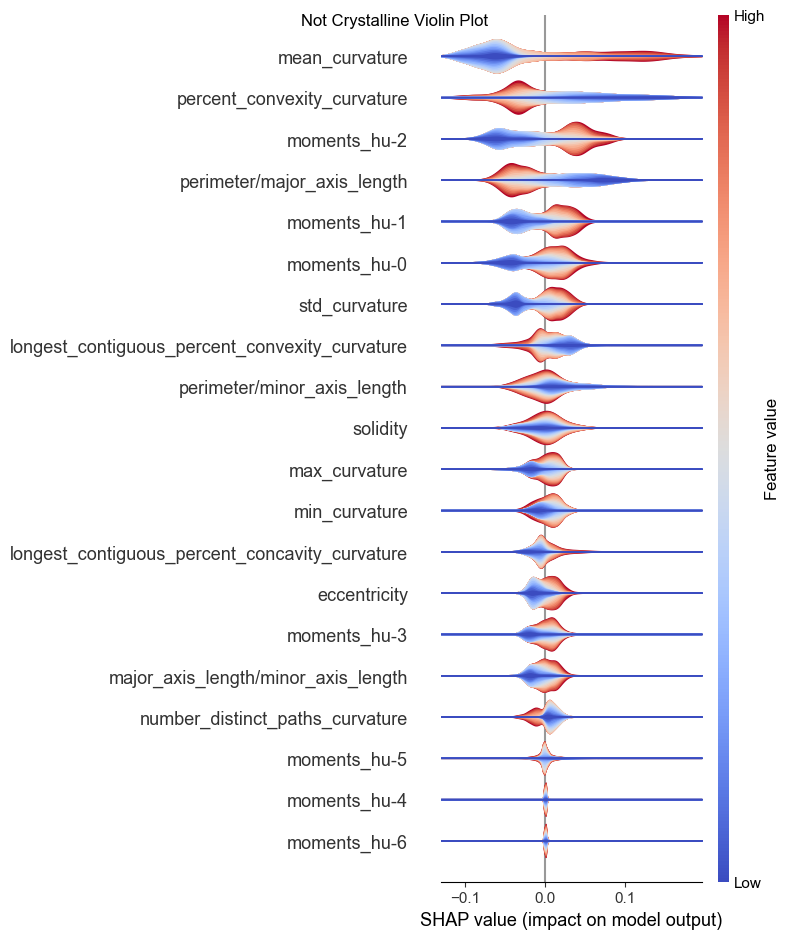

In [ ]:

shap_dict = {}
for model_run,name_mod in [
    (total,"C_MC_I"),
    (C_v_MC,"C_MC"),
    (Crys_v_Nocrys,"C-MC_I")]:
    explainer,shap_values = shapley_model_review(model_run,name_mod)
    shap_dict[name_mod] = (explainer,shap_values)


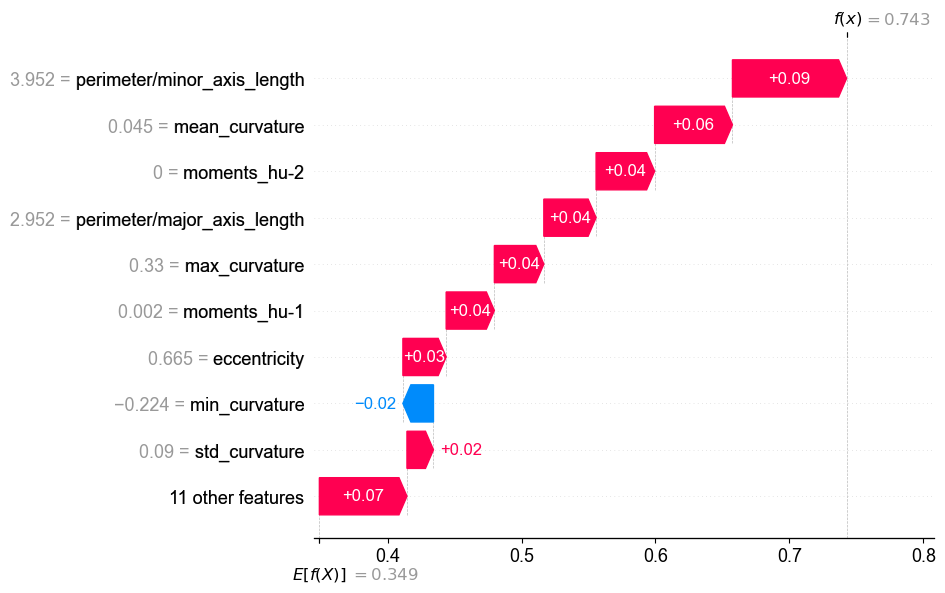

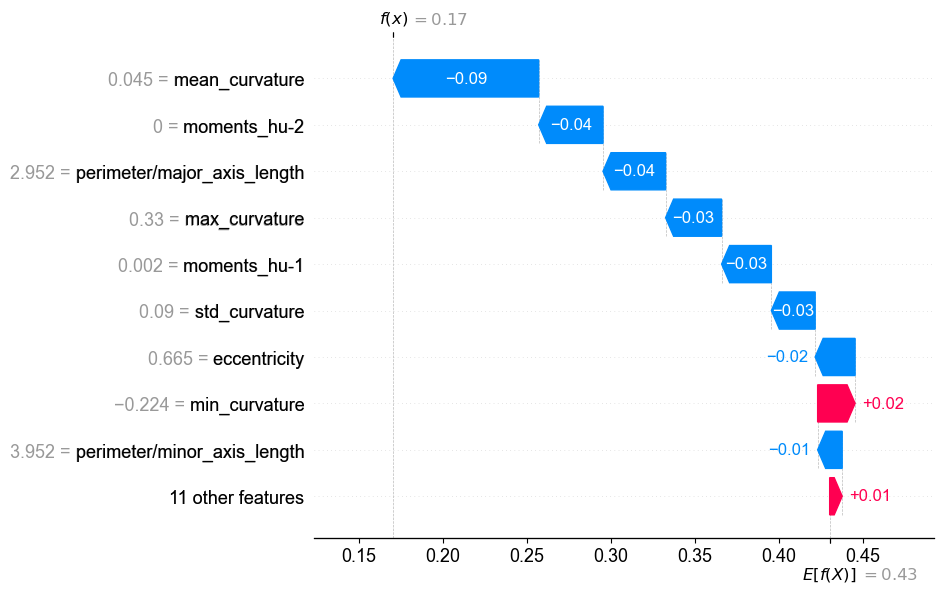

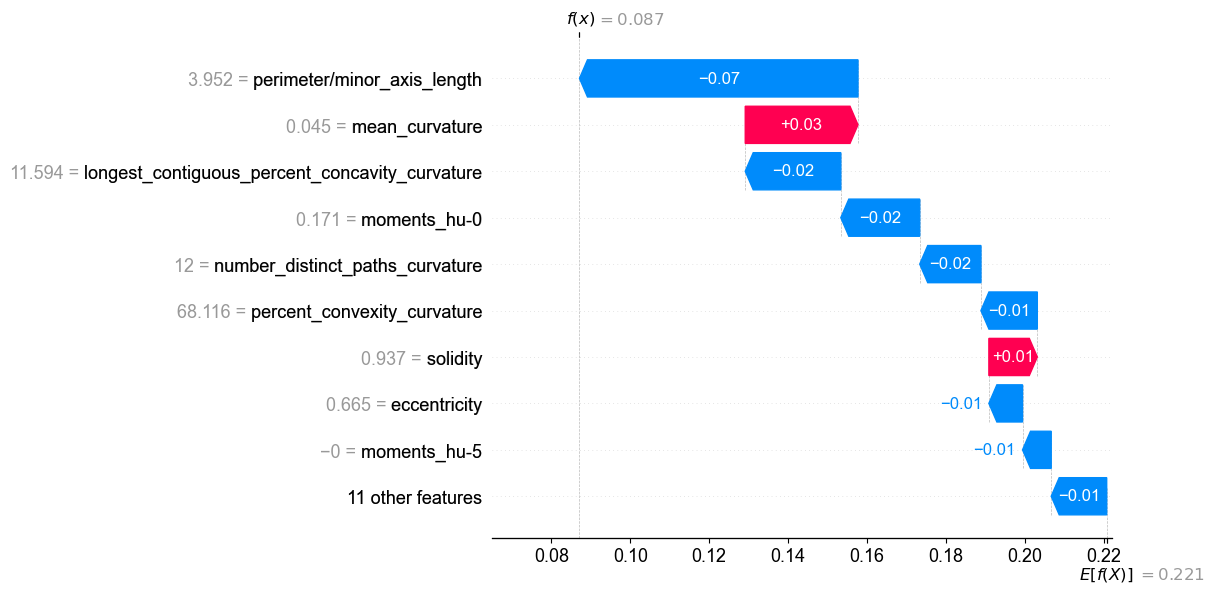

In [ ]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[0,:,0]) # Crystal
shap.plots.waterfall(shap_values[0,:,1]) # Incomplete
shap.plots.waterfall(shap_values[0,:,2]) # Multicrystal

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


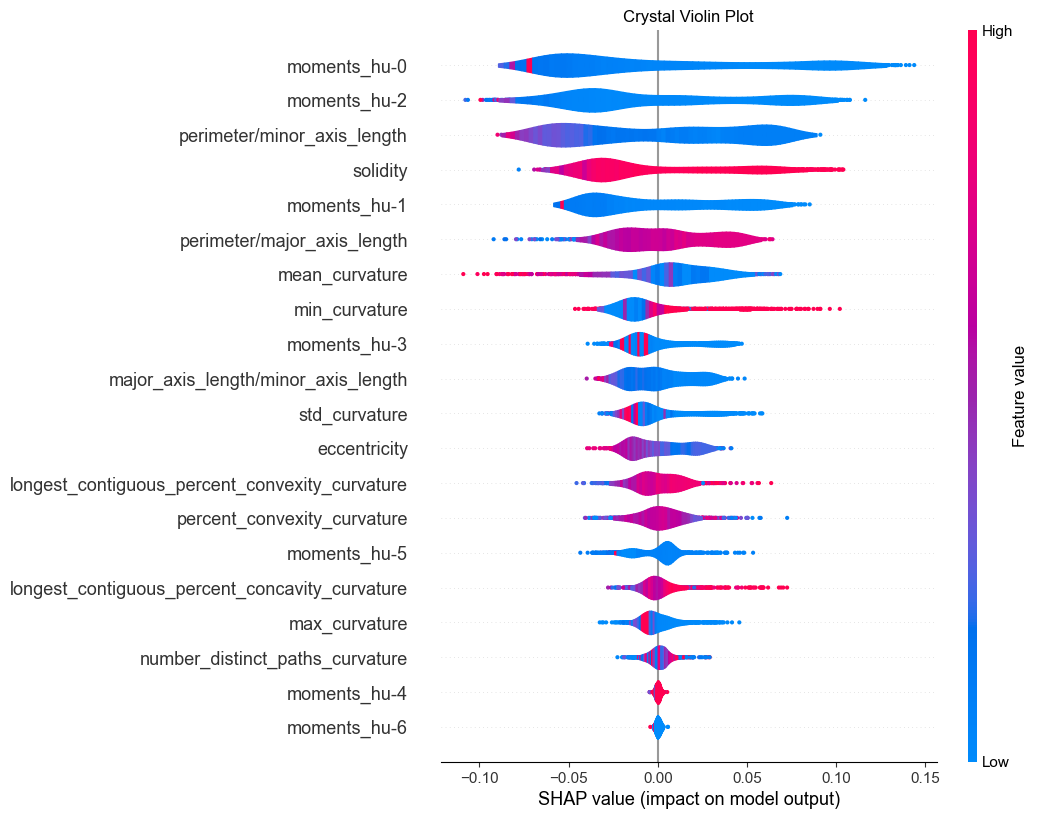

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.plots.violin(shap_values[:,:,0],show=False) # Crystal
plt.title("Crystal Violin Plot")
plt.show()
plt.savefig("S1_Shapley_Crystal.png")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


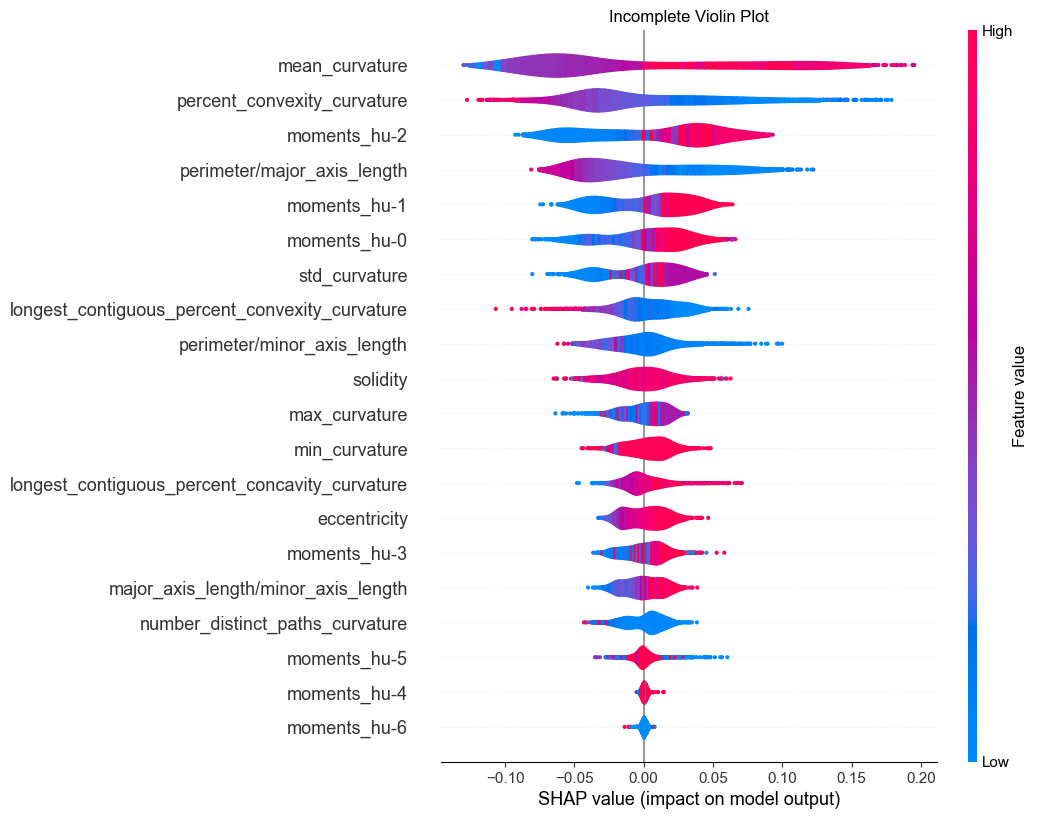

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.plots.violin(shap_values[:,:,1],show=False) # Incomplete
plt.title("Incomplete Violin Plot")
plt.show()
plt.savefig("S1_Shapley_Incomplete.png")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


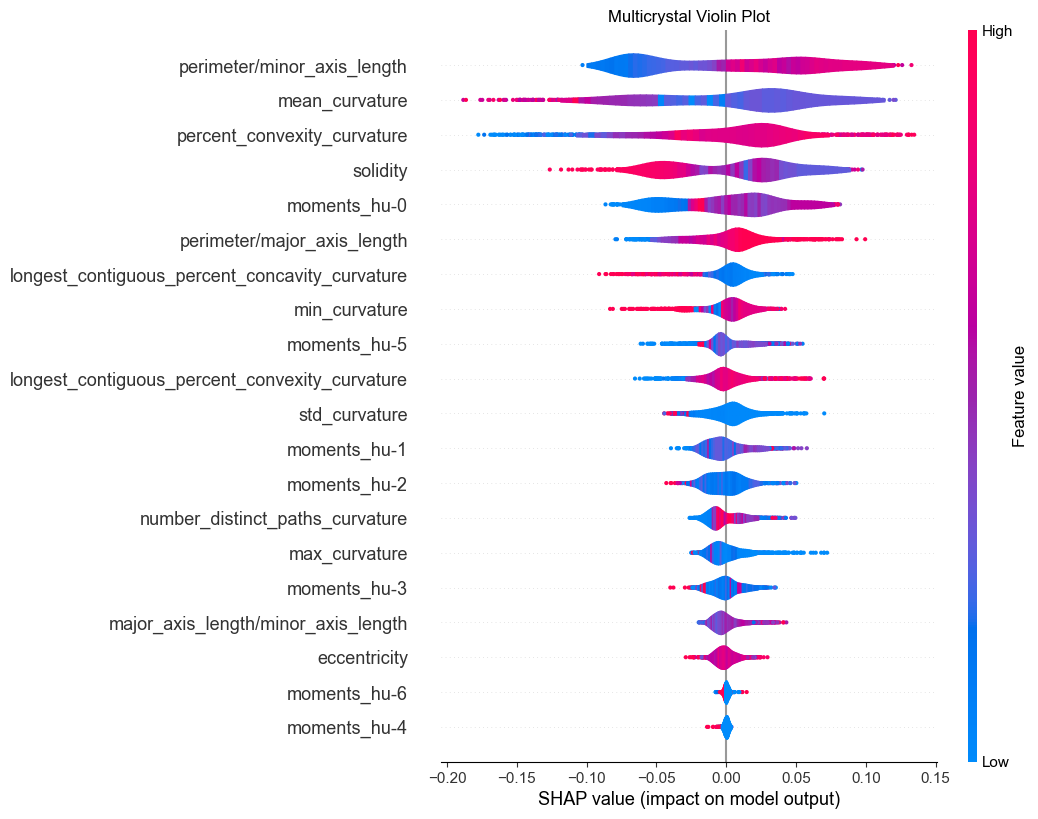

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.plots.violin(shap_values[:,:,2],show=False) # Multicrystal
plt.title("Multicrystal Violin Plot")
plt.show()
plt.savefig("S1_Shapley_Multicrystal.png")

In [ ]:
# Now check the multiscale models